In [19]:
# https://www.youtube.com/watch?app=desktop&v=G_UYXzGuqvM
#https://levelup.gitconnected.com/fourier-analysis-networks-fans-are-here-to-break-barriers-in-ai-1c521c6656bc

Suduko Solver for fun

In [20]:
board = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

for i, row in enumerate(board):
    print(row)

[5, 3, 0, 0, 7, 0, 0, 0, 0]
[6, 0, 0, 1, 9, 5, 0, 0, 0]
[0, 9, 8, 0, 0, 0, 0, 6, 0]
[8, 0, 0, 0, 6, 0, 0, 0, 3]
[4, 0, 0, 8, 0, 3, 0, 0, 1]
[7, 0, 0, 0, 2, 0, 0, 0, 6]
[0, 6, 0, 0, 0, 0, 2, 8, 0]
[0, 0, 0, 4, 1, 9, 0, 0, 5]
[0, 0, 0, 0, 8, 0, 0, 7, 9]


In [21]:
import numpy as np

print(np.matrix(board))

[[5 3 0 0 7 0 0 0 0]
 [6 0 0 1 9 5 0 0 0]
 [0 9 8 0 0 0 0 6 0]
 [8 0 0 0 6 0 0 0 3]
 [4 0 0 8 0 3 0 0 1]
 [7 0 0 0 2 0 0 0 6]
 [0 6 0 0 0 0 2 8 0]
 [0 0 0 4 1 9 0 0 5]
 [0 0 0 0 8 0 0 7 9]]


In [22]:
def possible(y,x,n):
    global board
    for i in range(0,9):
        if board[y][i] == n:
            return False
    for i in range(0,9):
        if board[i][x] == n:
            return False
    x0 = (x//3)*3
    y0 = (y//3)*3
    for i in range(0,3):
        for j in range(0,3):
            if board[y0+i][x0+j] == n:
                return False
    return True
        

In [23]:
def solve():
    global board
    for y in range(9):
        for x in range(9):
            if board[y][x] == 0:
                for n in range(1, 10):
                    if possible(y, x, n):
                        board[y][x] = n
                        solve()
                        board[y][x] = 0
                return
    print(np.matrix(board))
    input("More?")

In [24]:
solve()

[[5 3 4 6 7 8 9 1 2]
 [6 7 2 1 9 5 3 4 8]
 [1 9 8 3 4 2 5 6 7]
 [8 5 9 7 6 1 4 2 3]
 [4 2 6 8 5 3 7 9 1]
 [7 1 3 9 2 4 8 5 6]
 [9 6 1 5 3 7 2 8 4]
 [2 8 7 4 1 9 6 3 5]
 [3 4 5 2 8 6 1 7 9]]


FAN vs KAN vs MLP work in pytorch

In [13]:
import numpy as np
from torch.utils.data import Dataset
import torch

#take two timer series and train our models on those datasets 
# https://github.com/jbrownlee/Datasets
# create new symbolicDataset to be sin(2 * pi * x^2) + cos3 * pi * x^2)
# contained in self.y


class SymbolicDataset(Dataset):
    def __init__(self, num_samples, noise_level):
        # Inputs obtained from sampling a uniform distribution
        self.x = np.random.uniform(0, 10, (num_samples, 1)).astype(np.float32)
        #Outputs calculated as per the periodic formula (shown above)
        self.y = (np.sin(2 * np.pi * self.x ) + np.cos(3 * np.pi * self.x)).astype(np.float32)
        #Noise addition
        self.y += noise_level * np.random.randn(*self.y.shape).astype(np.float32)

    # Method that returns the number of samples in the dataset
    def __len__(self):
        return len(self.x)
    
    # Method that retrieves the sample at index 'idx'
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x[idx])
        y = torch.from_numpy(self.y[idx])
        return x, y

In [14]:
# Create an instance of the SymbolicDataset class
dataset = SymbolicDataset(num_samples=1000, noise_level=0.1)

# Example of how to retrieve a sample from the dataset
sample_x, sample_y = dataset[0]
print(f"Sample x: {sample_x}, Sample y: {sample_y}")

Sample x: tensor([7.1049]), Sample y: tensor([0.0734])


In [15]:
import torch
import torch.nn as nn

class FANLayer(nn.Module):
    def __init__(self, in_features, d_p, d_p_bar, activation=nn.GELU()):
        super().__init__()
        self.Wp = nn.Parameter(torch.randn(in_features, d_p))
        self.Wp_bar = nn.Parameter(torch.randn(in_features, d_p_bar))
        self.Bp_bar = nn.Parameter(torch.zeros(d_p_bar))
        self.activation = activation 

    def forward(self, x):
        cos_term = torch.cos(torch.matmul(x, self.Wp))
        sin_term = torch.sin(torch.matmul(x, self.Wp))
        non_periodic_term = self.activation(torch.matmul(x, self.Wp_bar) + self.Bp_bar)
        return torch.cat([cos_term, sin_term, non_periodic_term], dim=-1)
    
class FAN(nn.Module):
    def __init__(self, in_features, hidden_dim, num_layers, activation=nn.GELU()):
        super().__init__()

        self.num_layers = num_layers 
        self.layers = nn.ModuleList()

        # d_p set to a quarter of the hidden dimension as per the original research paper
        d_p = hidden_dim // 4 
        d_p_bar = hidden_dim
        
        # Implementation of layers before the last layer
        for _ in range(num_layers - 1):
            self.layers.append(FANLayer(in_features, d_p, d_p_bar, activation))
            # Updated after each layer to match the output dimension of the previous layer
            in_features = 2 * d_p + d_p_bar 
        
        # Parameters for the final layer
        self.WL = nn.Parameter(torch.randn(in_features, 1))
        self.BL = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        # Implementation of the final layer
        return torch.matmul(x, self.WL) + self.BL

class FAN2D(nn.Module): 
    def __init__(self, in_channels, hidden_dim, num_layers, activation=nn.GELU()): 
        super().__init__() 
        
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=5, padding=2) 
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1) 
        self.flatten = nn.Flatten() 
        self.fan = FAN(hidden_dim * 32 * 32, hidden_dim, num_layers, activation) 
        
    def forward(self, x): 
        x = self.conv1(x) 
        x = self.conv2(x) 
        x = self.flatten(x) 
        x = self.fan(x) 
        return x
    
    
'''
example usage
model = FAN2D(in_channels=3, hidden_dim=64, num_layers=3) 
input_tensor = torch.randn(1, 3, 32, 32) # Example input tensor with shape (batch_size, channels, height, width) 
output = model(input_tensor) print(output.shape)
'''

In [16]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_dim, num_layers):
        super().__init__()

        layers = []
        
        # Implementation of layers before the last layer
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(in_features, hidden_dim))
            layers.append(nn.GELU()) #GELU activation similar to the FAN
            in_features = hidden_dim
        
        # Implementation of the last layer
        layers.append(nn.Linear(hidden_dim, 1))

        # Constructing a Sequential neural network with the layers
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [17]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
# Defining device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(train_dataset, val_dataset, model, epochs, batch_size, lr, model_name):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Using the MSE loss
    criterion = nn.MSELoss()

    # Using the AdamW optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * x_batch.size(0)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in val_dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = model(x_batch)
                loss = criterion(preds, y_batch)
                epoch_val_loss += loss.item() * x_batch.size(0)

        # Computing average losses
        epoch_train_loss /= len(train_dataset)
        epoch_val_loss /= len(val_dataset)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Printing losses every 50 epochs
        if epoch % 50 == 0 or epoch == 1 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} - {model_name} Training Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

    return train_losses, val_losses

In [18]:
import torch
from torch.utils.data import random_split

# Defining device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Device check
print(f"Using device: {device}")
#print(f"FAN model is on device: {next(fan_model.parameters()).device}")
#print(f"MLP model is on device: {next(mlp_model.parameters()).device}")

# Preparing dataset
dataset = SymbolicDataset(num_samples=1000, noise_level=0.1)

# Splitting dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Preparing models
fan_model = FAN(in_features=1, hidden_dim=32, num_layers=3).to(device)
mlp_model = MLP(in_features=1, hidden_dim=32, num_layers=3).to(device)

# Training the FAN model
print("\nStarting training for FAN model...")
fan_train_losses, fan_val_losses = train_model(train_dataset, val_dataset, fan_model, epochs=500, batch_size=32, lr=0.001, model_name="FAN")

# Training the MLP model
print("\nStarting training for MLP model...")
mlp_train_losses, mlp_val_losses = train_model(train_dataset, val_dataset, mlp_model, epochs=500, batch_size=32, lr=0.001, model_name="MLP")

Using device: cpu

Starting training for FAN model...


Training FAN:   0%|          | 2/500 [00:00<01:23,  5.94it/s]

Epoch 1/500 - FAN Training Loss: 8080.950703, Validation Loss: 4199.742227


Training FAN:  10%|█         | 51/500 [00:08<01:05,  6.90it/s]

Epoch 50/500 - FAN Training Loss: 1.077282, Validation Loss: 1.012422


Training FAN:  20%|██        | 101/500 [00:15<00:53,  7.43it/s]

Epoch 100/500 - FAN Training Loss: 0.417323, Validation Loss: 0.335201


Training FAN:  30%|███       | 151/500 [00:21<00:42,  8.29it/s]

Epoch 150/500 - FAN Training Loss: 0.209714, Validation Loss: 0.175013


Training FAN:  40%|████      | 201/500 [00:30<00:45,  6.61it/s]

Epoch 200/500 - FAN Training Loss: 0.099047, Validation Loss: 0.090240


Training FAN:  50%|█████     | 251/500 [00:37<00:34,  7.22it/s]

Epoch 250/500 - FAN Training Loss: 0.048715, Validation Loss: 0.045869


Training FAN:  60%|██████    | 301/500 [00:45<00:27,  7.37it/s]

Epoch 300/500 - FAN Training Loss: 0.029167, Validation Loss: 0.028327


Training FAN:  70%|███████   | 351/500 [00:52<00:18,  8.27it/s]

Epoch 350/500 - FAN Training Loss: 0.028805, Validation Loss: 0.026246


Training FAN:  80%|████████  | 401/500 [01:00<00:16,  6.03it/s]

Epoch 400/500 - FAN Training Loss: 0.030148, Validation Loss: 0.020996


Training FAN:  90%|█████████ | 451/500 [01:07<00:06,  7.81it/s]

Epoch 450/500 - FAN Training Loss: 0.018832, Validation Loss: 0.024964


Training FAN: 100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Epoch 500/500 - FAN Training Loss: 0.038914, Validation Loss: 0.050759

Starting training for MLP model...


Training MLP:   0%|          | 1/500 [00:00<01:06,  7.51it/s]

Epoch 1/500 - MLP Training Loss: 1.158552, Validation Loss: 1.138061


Training MLP:  10%|█         | 52/500 [00:04<00:38, 11.62it/s]

Epoch 50/500 - MLP Training Loss: 1.012223, Validation Loss: 1.093399


Training MLP:  20%|██        | 102/500 [00:09<00:35, 11.19it/s]

Epoch 100/500 - MLP Training Loss: 1.004307, Validation Loss: 1.083189


Training MLP:  30%|███       | 151/500 [00:14<00:44,  7.90it/s]

Epoch 150/500 - MLP Training Loss: 1.001402, Validation Loss: 1.079983


Training MLP:  40%|████      | 200/500 [00:18<00:28, 10.68it/s]

Epoch 200/500 - MLP Training Loss: 0.998652, Validation Loss: 1.077699


Training MLP:  50%|█████     | 252/500 [00:23<00:22, 10.90it/s]

Epoch 250/500 - MLP Training Loss: 0.999476, Validation Loss: 1.077123


Training MLP:  60%|██████    | 302/500 [00:28<00:18, 10.75it/s]

Epoch 300/500 - MLP Training Loss: 0.994083, Validation Loss: 1.072431


Training MLP:  70%|███████   | 350/500 [00:33<00:17,  8.68it/s]

Epoch 350/500 - MLP Training Loss: 0.958644, Validation Loss: 1.028820


Training MLP:  80%|████████  | 400/500 [00:38<00:09, 10.57it/s]

Epoch 400/500 - MLP Training Loss: 0.888498, Validation Loss: 0.924794


Training MLP:  90%|█████████ | 452/500 [00:43<00:04, 11.11it/s]

Epoch 450/500 - MLP Training Loss: 0.845543, Validation Loss: 0.857444


Training MLP: 100%|██████████| 500/500 [00:48<00:00, 10.37it/s]

Epoch 500/500 - MLP Training Loss: 0.817503, Validation Loss: 0.816929


In [21]:
import matplotlib.pyplot as plt
# Defining device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(fan_model, mlp_model):
    # Creating test dataset sampled evenly (compare it with training data)
    x_test = torch.linspace(0, 10, 1000).reshape(-1, 1).float().to(device)
    y_test = np.sin(2 * np.pi * x_test.cpu().numpy()) + np.cos(3 * np.pi * x_test.cpu().numpy())
    #(np.sin(2 * np.pi * self.x ) + np.cos(3 * np.pi * self.x)).astype(np.float32)
    
    
    fan_model.eval()
    mlp_model.eval()

    with torch.no_grad():
        fan_pred = fan_model(x_test).cpu().numpy()
        mlp_pred = mlp_model(x_test).cpu().numpy()

    # Plotting the results
    plt.figure(figsize=(12, 6))

    plt.plot(x_test.cpu().numpy(), y_test, label="True Function", color="black", linestyle="dashed")
    plt.plot(x_test.cpu().numpy(), fan_pred, label="FAN Prediction", color="blue", alpha=0.7)
    plt.plot(x_test.cpu().numpy(), mlp_pred, label="MLP Prediction", color="red", alpha=0.7)
    
    plt.legend()

    plt.title("Comparison of FAN and MLP on Symbolic Dataset")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

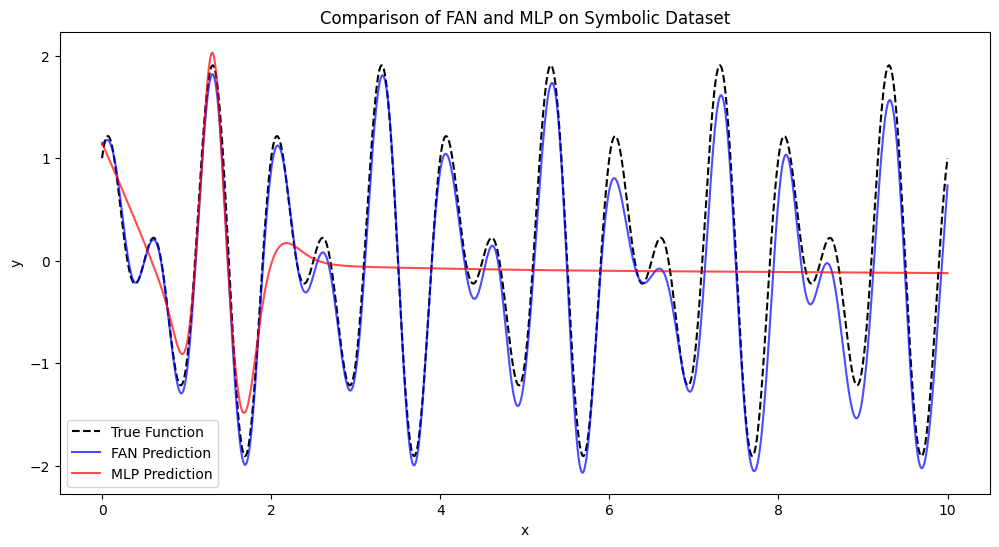

In [22]:
evaluate_model(fan_model, mlp_model)

In [ ]:
# The Gated FAN layer
class FANLayerGated(nn.Module):
    def __init__(self, in_features, d_p, d_p_bar, activation=nn.GELU(), gated=True):
        super().__init__()
        self.Wp = nn.Parameter(torch.randn(in_features, d_p))
        self.Wp_bar = nn.Parameter(torch.randn(in_features, d_p_bar))
        self.Bp_bar = nn.Parameter(torch.zeros(d_p_bar))
        self.activation = activation
        if gated:
            self.gate = nn.Parameter(torch.randn(1))

    def forward(self, x):
        cos_term = torch.cos(torch.matmul(x, self.Wp))
        sin_term = torch.sin(torch.matmul(x, self.Wp))
        non_periodic_term = self.activation(torch.matmul(x, self.Wp_bar) + self.Bp_bar)
        
        if hasattr(self, 'gate'):
            gate = torch.sigmoid(self.gate)
            cos_term = gate * cos_term
            sin_term = gate * sin_term
            non_periodic_term = (1 - gate) * non_periodic_term

        return torch.cat([cos_term, sin_term, non_periodic_term], dim=-1)

# The Gated FAN model
class FANGated(nn.Module):
    def __init__(self, in_features, hidden_dim, num_layers, activation=nn.GELU(), gated=True):
        super().__init__()
        self.layers = nn.ModuleList()
        
        d_p = hidden_dim // 4
        d_p_bar = hidden_dim

        for _ in range(num_layers - 1):
            self.layers.append(FANLayerGated(in_features, d_p, d_p_bar, activation, gated))
            in_features = 2 * d_p + d_p_bar  

        self.output_layer = nn.Linear(in_features, 1) 

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)